In [ ]:
!free -h --si | awk '/Mem:/{print $2}'

13G


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!nvidia-smi

Sat May 21 10:30:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q -U watermark

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.7 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision,pytorch-gpu

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy      : 1.21.6
pandas     : 1.3.5
torch      : 1.11.0+cu113
torchvision: 0.12.0+cu113
pytorch-gpu: not installed



In [ ]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd 
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict
from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ['#01BEFE', "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2022-05-21 10:30:54--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  23.9MB/s    in 12s     

2022-05-21 10:31:07 (21.5 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [ ]:

train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

In [ ]:

def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths, n_row = 11):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, n_row)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

# Wybieram te znaki które występują w polsce
Znaki zakazu
1.   Ograniczenia prędkości 
  - 20 - 00000, 
  - 30 - 00001, 
  - 50 - 00002,
  - 60 - 00003,
  - 70 - 00004,
  - 80 - 00005,
  - 100 - 00006,
  - 120 - 00007
2. Zakaz wyprzedzania - 00008
3. Zakaz wyprzedzania dla ciężarówek - 00009
4. Droga z pierszeństwem -00012
5. STOP - 00014
6. Zakaz ruchu w obu kierunkach - 00015
7. Zakaz ruchu pojazdów ciężarowych -00016
8. Zakaz wjazdu - 00017
9. Koniec zakazów - 00032
10. Znaki nakazu
  - nakaz jazdy w prawo - 00033
  - nakaz jazdy w lewo - 00034
  - nakaz jazdy na wprost - 00035
  - nakaz jazdy na jazdy na wprost lub prawo - 00036
  - nakaz jazdy na jazdy na wprost lub lewo - 00037
  - nakaz jazdy z lewej strony - 00038
  - nakaz jazdy z prawej strony - 00039
  - skrzyżowanie o ruchu okrężnym - 00040
  - koniec zakazu wyprzedzania - 00041
  - koniec zakazu wyprzedzania dla ciężarówek - 00042

więc ostatecznie ywbieramy
0,1,2,3,4,5,6,7,8,9,12,14,15,16,17,32,33,34,35,36,37,38,39,40,41,42

In [ ]:
# img_path = glob(f'{train_folders[41]}/*ppm')[20]

# show_image(img_path)

In [ ]:
train_folders

['GTSRB/Final_Training/Images/00000',
 'GTSRB/Final_Training/Images/00001',
 'GTSRB/Final_Training/Images/00002',
 'GTSRB/Final_Training/Images/00003',
 'GTSRB/Final_Training/Images/00004',
 'GTSRB/Final_Training/Images/00005',
 'GTSRB/Final_Training/Images/00006',
 'GTSRB/Final_Training/Images/00007',
 'GTSRB/Final_Training/Images/00008',
 'GTSRB/Final_Training/Images/00009',
 'GTSRB/Final_Training/Images/00010',
 'GTSRB/Final_Training/Images/00011',
 'GTSRB/Final_Training/Images/00012',
 'GTSRB/Final_Training/Images/00013',
 'GTSRB/Final_Training/Images/00014',
 'GTSRB/Final_Training/Images/00015',
 'GTSRB/Final_Training/Images/00016',
 'GTSRB/Final_Training/Images/00017',
 'GTSRB/Final_Training/Images/00018',
 'GTSRB/Final_Training/Images/00019',
 'GTSRB/Final_Training/Images/00020',
 'GTSRB/Final_Training/Images/00021',
 'GTSRB/Final_Training/Images/00022',
 'GTSRB/Final_Training/Images/00023',
 'GTSRB/Final_Training/Images/00024',
 'GTSRB/Final_Training/Images/00025',
 'GTSRB/Fina

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  from ipykernel import kernelapp as app


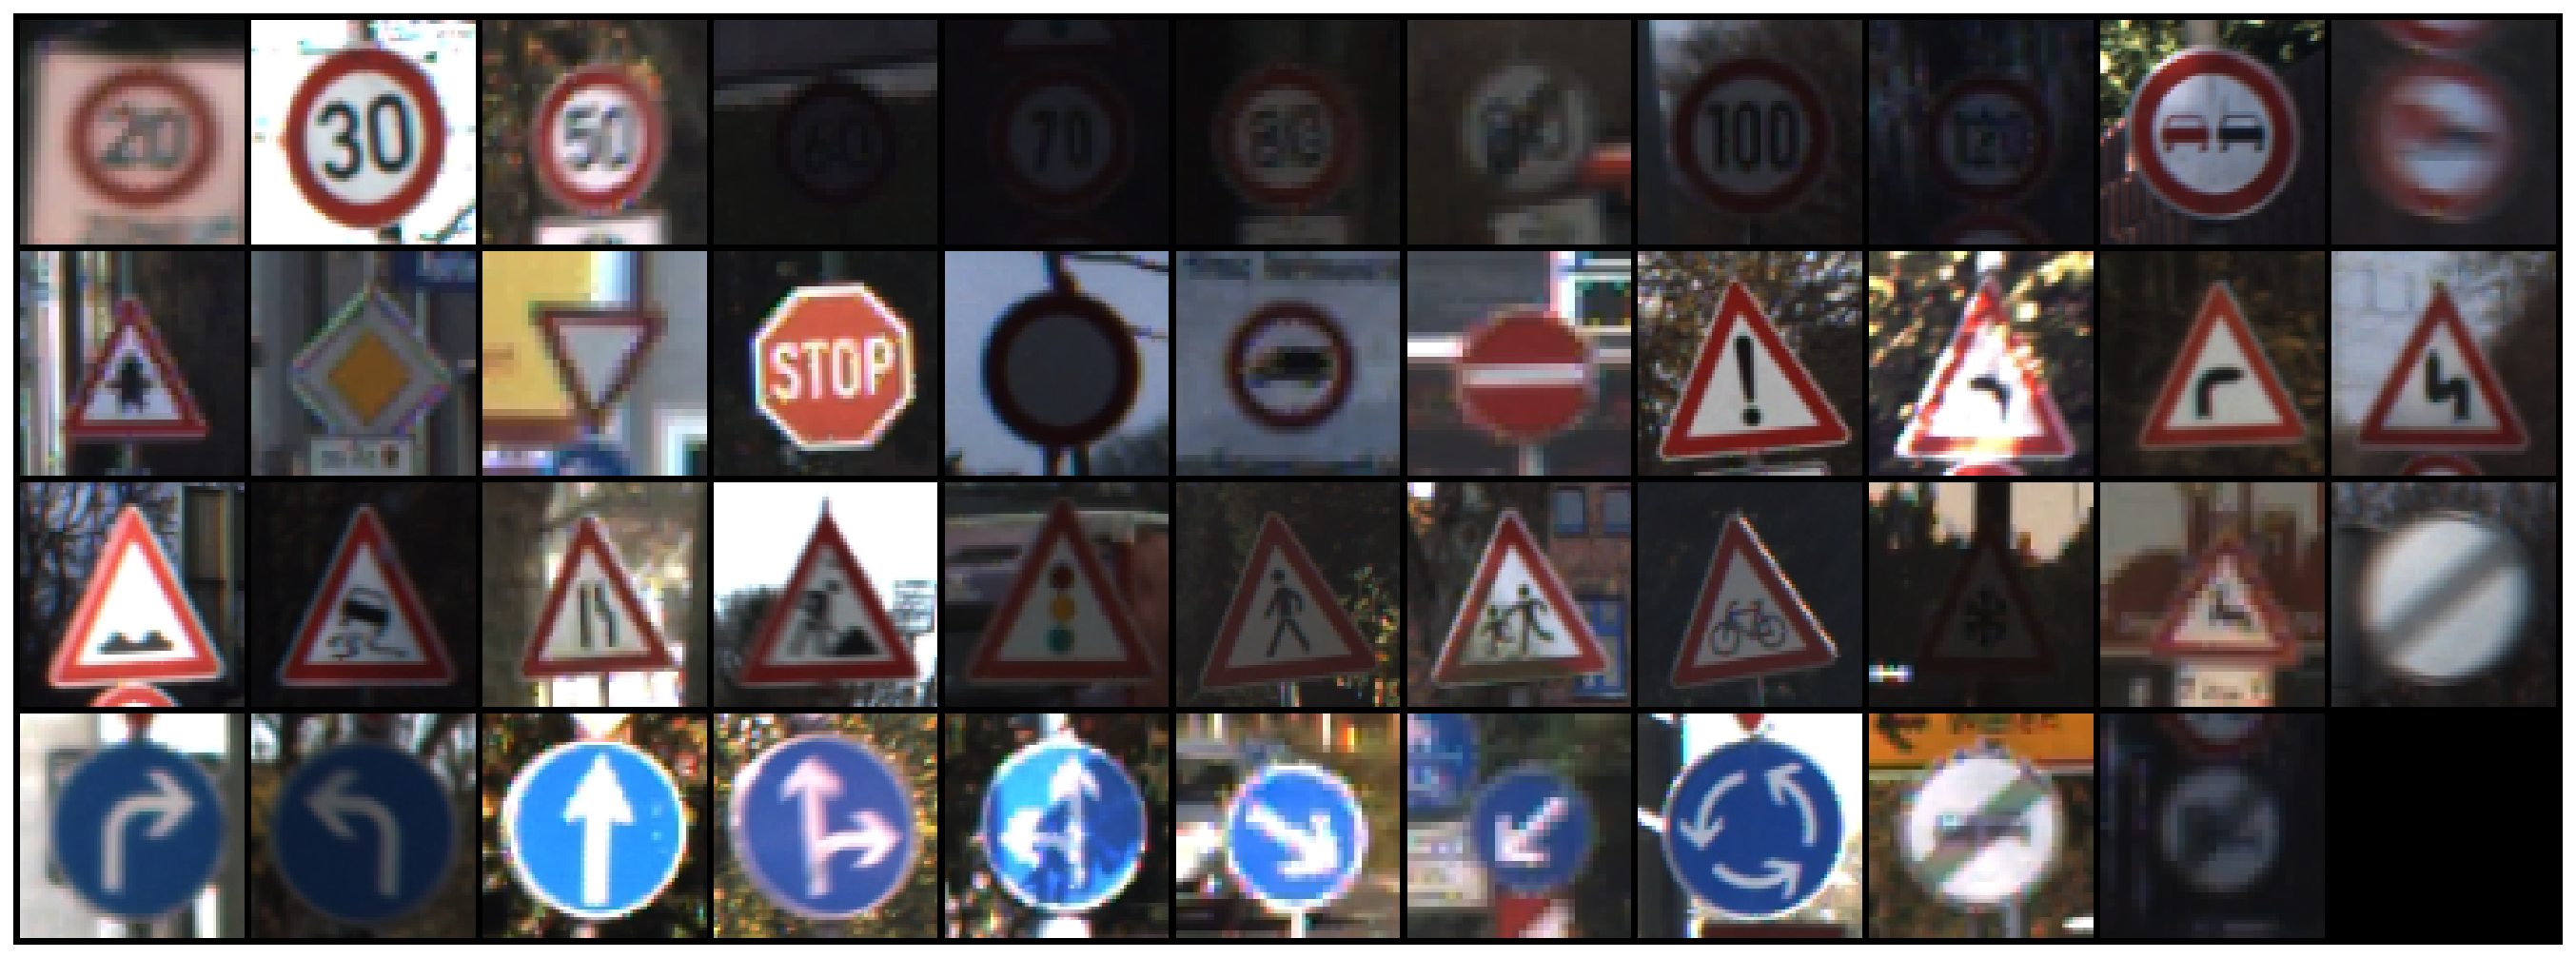

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

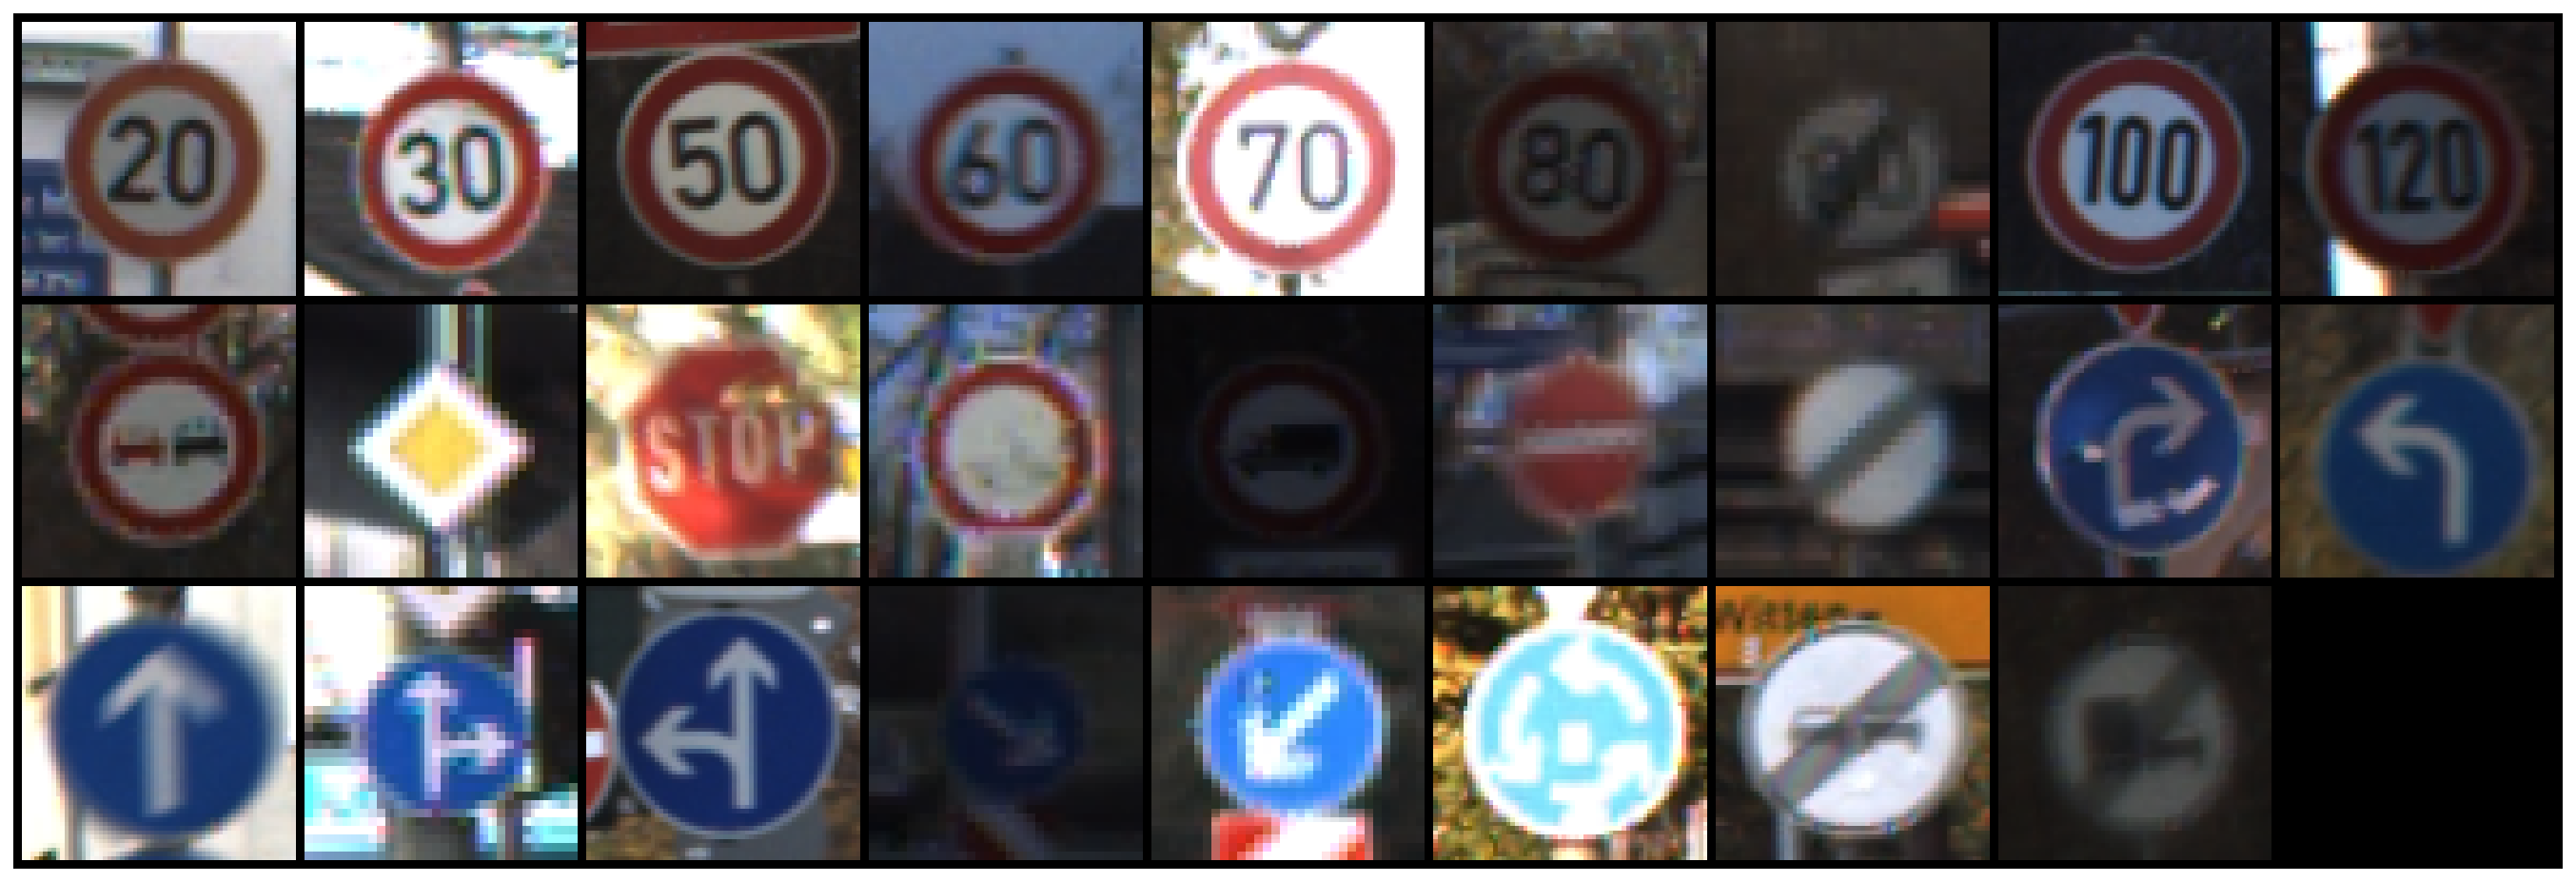

In [ ]:
base_folder_path = 'GTSRB/Final_Training/Images/'

train_folders_for_me = ['00000', '00001', '00002','00003', '00004', '00005', '00006', '00007', '00008', '00009', '00012', '00014', '00015', '00016', '00017', '00032',
                        '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042']

train_folders_for_me = [base_folder_path + x for x in train_folders_for_me]
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders_for_me]
show_sign_grid(sample_images, n_row=9)

In [ ]:
class_names = ['B-33_20', 'B-33_30', 'B-33_50', 'B-33_60', 'B-33_70', 'B-33_80', 'B-34_80', 'B-33_100', 'B-33_120', 'B-25', 'B-26', 
               'D-1', 'B-20', 'B-1', 'B-5', 'B-2', 
               'B-42', 
               'C-2', 'C-4', 'C-5', 'C-6', 'C-7', 
               'C-9', 'C-10', 'C-12', 'B-27', 'B-28']

class_indices = [0,1,2,3,4,5,6,7,8,9,10,
                 12,14,15,16,17,
                 32,
                 33,34,35,36,37,38,39,40,41,42]

In [ ]:
sample_images

['GTSRB/Final_Training/Images/00000/00002_00019.ppm',
 'GTSRB/Final_Training/Images/00001/00030_00016.ppm',
 'GTSRB/Final_Training/Images/00002/00044_00026.ppm',
 'GTSRB/Final_Training/Images/00003/00040_00027.ppm',
 'GTSRB/Final_Training/Images/00004/00051_00021.ppm',
 'GTSRB/Final_Training/Images/00005/00033_00019.ppm',
 'GTSRB/Final_Training/Images/00006/00008_00005.ppm',
 'GTSRB/Final_Training/Images/00007/00022_00023.ppm',
 'GTSRB/Final_Training/Images/00008/00018_00023.ppm',
 'GTSRB/Final_Training/Images/00009/00030_00015.ppm',
 'GTSRB/Final_Training/Images/00012/00063_00008.ppm',
 'GTSRB/Final_Training/Images/00014/00018_00006.ppm',
 'GTSRB/Final_Training/Images/00015/00019_00019.ppm',
 'GTSRB/Final_Training/Images/00016/00002_00019.ppm',
 'GTSRB/Final_Training/Images/00017/00036_00011.ppm',
 'GTSRB/Final_Training/Images/00032/00001_00010.ppm',
 'GTSRB/Final_Training/Images/00033/00016_00022.ppm',
 'GTSRB/Final_Training/Images/00034/00004_00003.ppm',
 'GTSRB/Final_Training/Image

In [ ]:
class_names = ['20', '30', '50', '60', '70', '80', 'koniec_80', '100', '120', 'zakaz_wyprzedzania', 'zakaz_wyprzedzania_ciezarowki', 
               'droga_pierszenstwo','stop', 'zakaz_ruchu_w_obu_kierunkach', 'zakaz_ruchu_pojazdow_ciezarowych', 'zakaz_wjazdu', 
               'koniec_zakazow', 
               'nakaz_prawo', 'nakaz_lewo', 'nakaz_wprost', 'nakaz_prosto_prawo', 'nakaz_prosto_lewo', 
               'nakaz_z_prawej', 'nakaz_z_lewej', 'ruch_okrezny', 'zakaz_wyprzedzania', 'zakaz_wyprzedzania_ciezarowki']
# Lista odnosząca siędo zdjęcia wyżej

class_indices = [0,1,2,3,4,5,6,7,8,9,10,
                 12,14,15,16,17,
                 32,
                 33,34,35,36,37,38,39,40,41,42]

In [ ]:

# class_names = ['20', '30', '40', '50', '60', '70', '80', '100', '120', 'zakaz_wyprzedzania', 'zakaz_wyprzedzania_ciezarowki', 
#                'droga_pierszenstwo','stop', 'zakaz_ruchu_w_obu_kierunkach', 'zakaz_ruchu_pojazdow_ciezarowych', 'zakaz_wjazdu', 
#                'koniec_zakazow', 'nakaz_prawo', 'nakaz_lewo', 'nakaz_wprost', 'nakaz_prosto_prawo', 'nakaz_prosto_lewo', 
#                'nakaz_z_lewej', 'nakaz_z_prawej', 'ruch_okrezny', 'zakaz_wyprzedzania', 'zakaz_wyprzedzania_ciezarowki']

# class_indices = [0,1,2,3,4,5,6,7,8,9,12,14,15,16,17,32,33,34,35,36,37,38,39,40,41,42]

In [ ]:
len(class_indices)

27

In [ ]:
len(class_names)

27

In [ ]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
data_for_chart = []

for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  data_for_chart.append((class_name, len(image_paths)))
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

20: 210
30: 2220
50: 2250
60: 1410
70: 1980
80: 1860
koniec_80: 420
100: 1440
120: 1410
zakaz_wyprzedzania: 1470
zakaz_wyprzedzania_ciezarowki: 2010
droga_pierszenstwo: 2100
stop: 780
zakaz_ruchu_w_obu_kierunkach: 630
zakaz_ruchu_pojazdow_ciezarowych: 420
zakaz_wjazdu: 1110
koniec_zakazow: 240
nakaz_prawo: 689
nakaz_lewo: 420
nakaz_wprost: 1200
nakaz_prosto_prawo: 390
nakaz_prosto_lewo: 210
nakaz_z_prawej: 2070
nakaz_z_lewej: 300
ruch_okrezny: 360
zakaz_wyprzedzania: 240
zakaz_wyprzedzania_ciezarowki: 240


In [ ]:
data_for_chart_dict = dict(data_for_chart)

In [ ]:
list(data_for_chart_dict.keys())

['20',
 '30',
 '50',
 '60',
 '70',
 '80',
 'koniec_80',
 '100',
 '120',
 'zakaz_wyprzedzania',
 'zakaz_wyprzedzania_ciezarowki',
 'droga_pierszenstwo',
 'stop',
 'zakaz_ruchu_w_obu_kierunkach',
 'zakaz_ruchu_pojazdow_ciezarowych',
 'zakaz_wjazdu',
 'koniec_zakazow',
 'nakaz_prawo',
 'nakaz_lewo',
 'nakaz_wprost',
 'nakaz_prosto_prawo',
 'nakaz_prosto_lewo',
 'nakaz_z_prawej',
 'nakaz_z_lewej',
 'ruch_okrezny']

In [ ]:
df = pd.DataFrame(data_for_chart).set_index(0)
df.index.rename('Rodzaj znaku', inplace=True)
# df = pd.DataFrame(lista).T.drop(columns=0)
# df['name'] = list(data_for_chart_dict.keys())
df.columns = ['Liczba zdjęć']
df = df.sort_values('Liczba zdjęć')

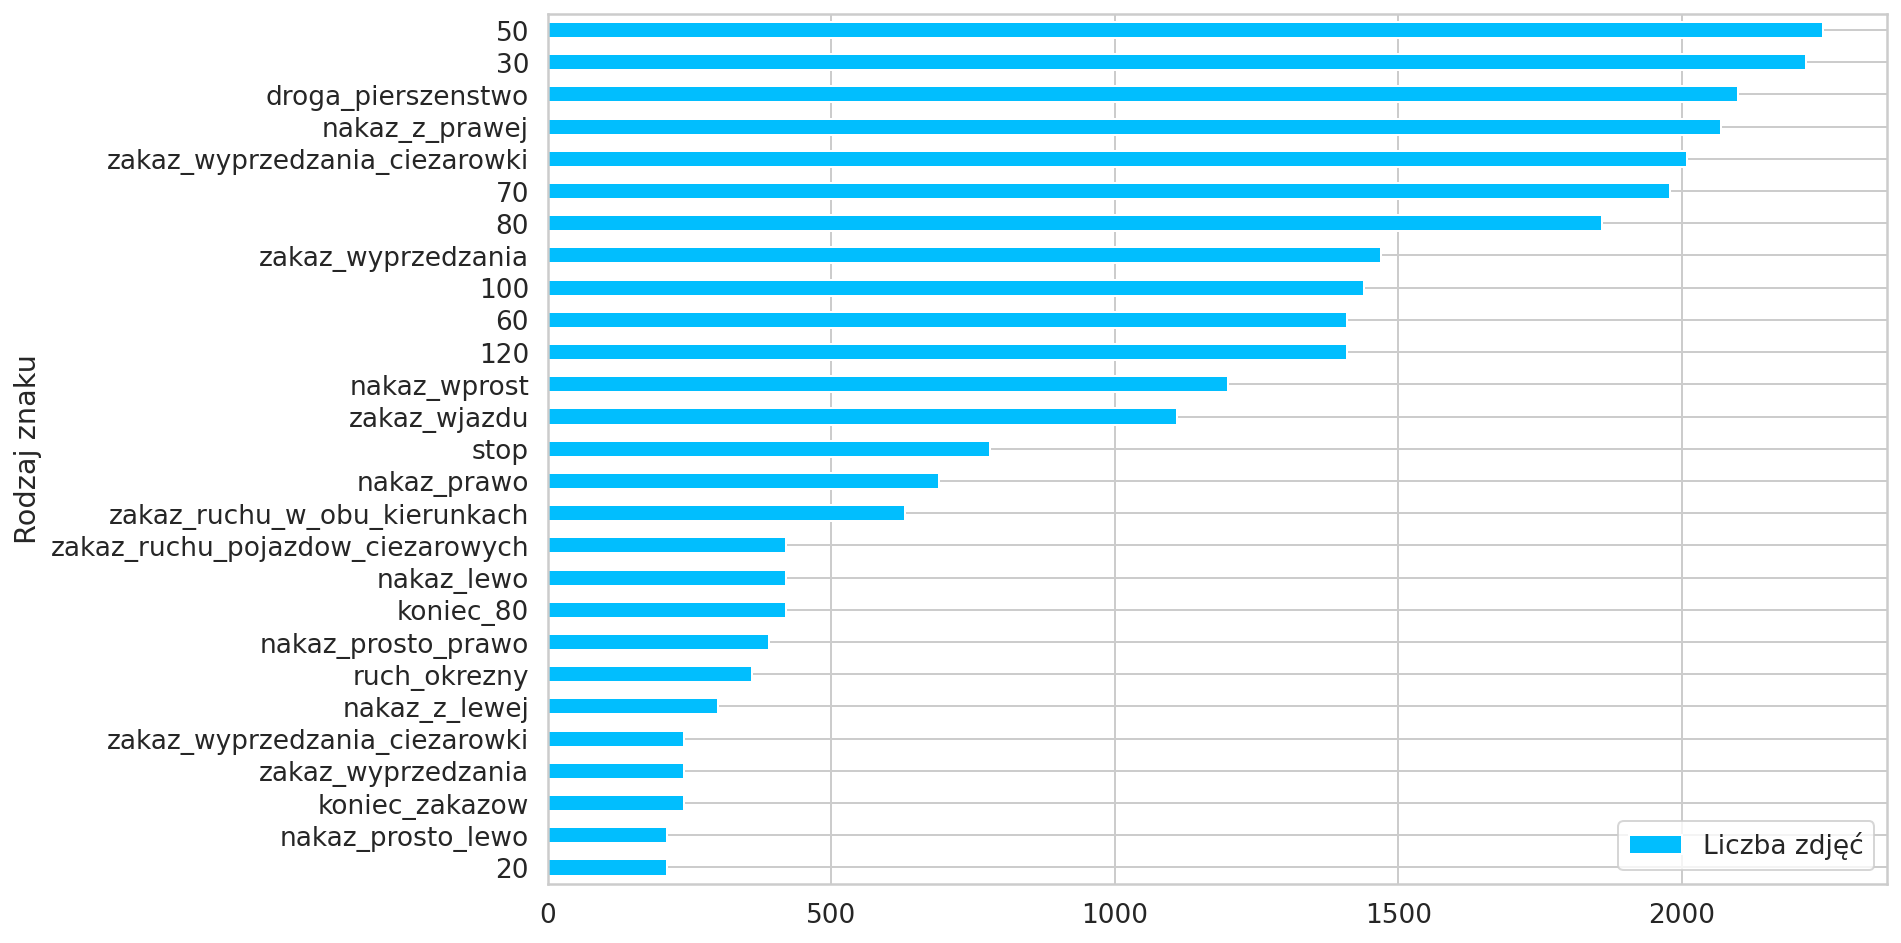

In [ ]:
df.plot.barh()

In [ ]:
# # plt.barh(range(len(data_for_chart_dict)), list(data_for_chart_dict.values()), align='center')
# plt.barh(range(len(data_for_chart_dict)), list(data_for_chart_dict.values()))


rcParams['figure.figsize'] = 16, 10
# plt.xticks(class_indices, rotation='vertical')
# plt.xticks(range(len(data_for_chart_dict)), list(data_for_chart_dict.keys()))

# data augmentation

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

# Data augmentatation
# From pytorch documentation https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256,scale=(0.5,1.0)),
  T.RandomRotation(degrees=15),
  # T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'test': 2801, 'train': 22144, 'val': 2803}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


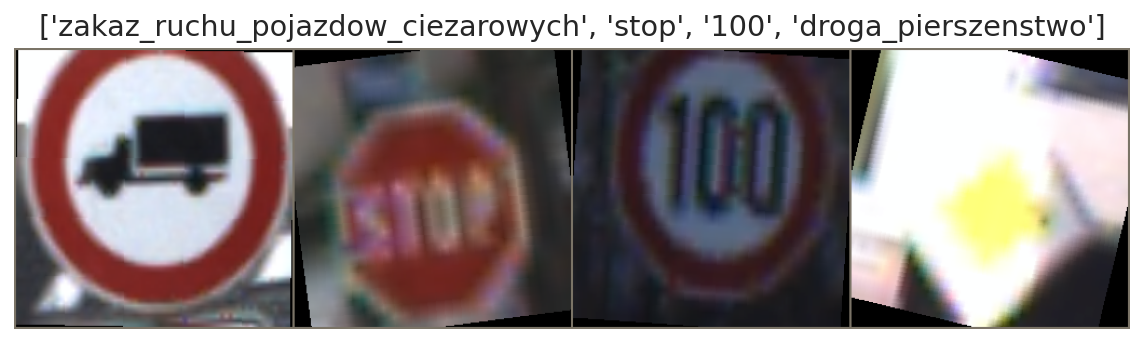

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

## First Model - bez niezdefiniowanych znaków

In [ ]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch: {epoch + 1}/{n_epochs}')
    print('-' * 25)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss: {train_loss:.5f} | accuracy: {train_acc:.5f}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val loss: {val_loss:.5f} | accuracy: {val_acc:.5f} \n')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

In [ ]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

In [ ]:
plot_training_history(history)

In [ ]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

In [ ]:
show_predictions(base_model, class_names, n_images=10)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
from matplotlib import rcParams
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  
  # plt.figure(figsize=(40, 20))
  # hmap.figure(figsize=(11,8))
  rcParams['figure.figsize'] = 30.7, 12.27
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

In [ ]:

cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

# Dodaję nową klasę "nieznany"

In [ ]:
unknown_indices = [
  i for i, f in enumerate(train_folders) \
  if i not in class_indices
]

len(unknown_indices)

16

## Stworzę folder dla klasy nieznany i dodam do niego kilka obrazów

In [ ]:
for ds in DATASETS:
  (DATA_DIR / ds / 'nieznany').mkdir(parents=True, exist_ok=True)

for ui in unknown_indices:
  image_paths = np.array(glob(f'{train_folders[ui]}/*.ppm'))
  image_paths = np.random.choice(image_paths, 50)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/nieznany/')

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'test': 2878, 'train': 22567, 'val': 2879}

In [ ]:
%%time

enchanced_model = create_model(len(class_names))
enchanced_model, history = train_model(enchanced_model, data_loaders, dataset_sizes, device)

Epoch: 1/3
-------------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss: 0.26937 | accuracy: 0.92861
Val loss: 0.00640 | accuracy: 0.99861 

Epoch: 2/3
-------------------------
Train loss: 0.03444 | accuracy: 0.99202
Val loss: 0.01247 | accuracy: 0.99722 

Epoch: 3/3
-------------------------
Train loss: 0.02422 | accuracy: 0.99459
Val loss: 0.00719 | accuracy: 0.99757 

Best val accuracy: 0.9986106286905175
CPU times: user 10min 32s, sys: 18.9 s, total: 10min 51s
Wall time: 11min 3s


In [ ]:
import pickle
filename = 'finalized_model_nieznany.sav'
pickle.dump(enchanced_model, open(filename, 'wb'))

In [ ]:
plot_training_history(history)

In [ ]:
show_image('nieznany_znak.png')

In [ ]:

def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [ ]:

def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

In [ ]:
pred = predict_proba(enchanced_model, 'nieznany_znak.png')
show_prediction_confidence(pred, class_names)

In [ ]:
show_image('stop.png')

In [ ]:
pred = predict_proba(enchanced_model, 'stop.png')
show_prediction_confidence(pred, class_names)

In [ ]:
pred = predict_proba(enchanced_model, 'second.jpg')
show_prediction_confidence(pred, class_names)

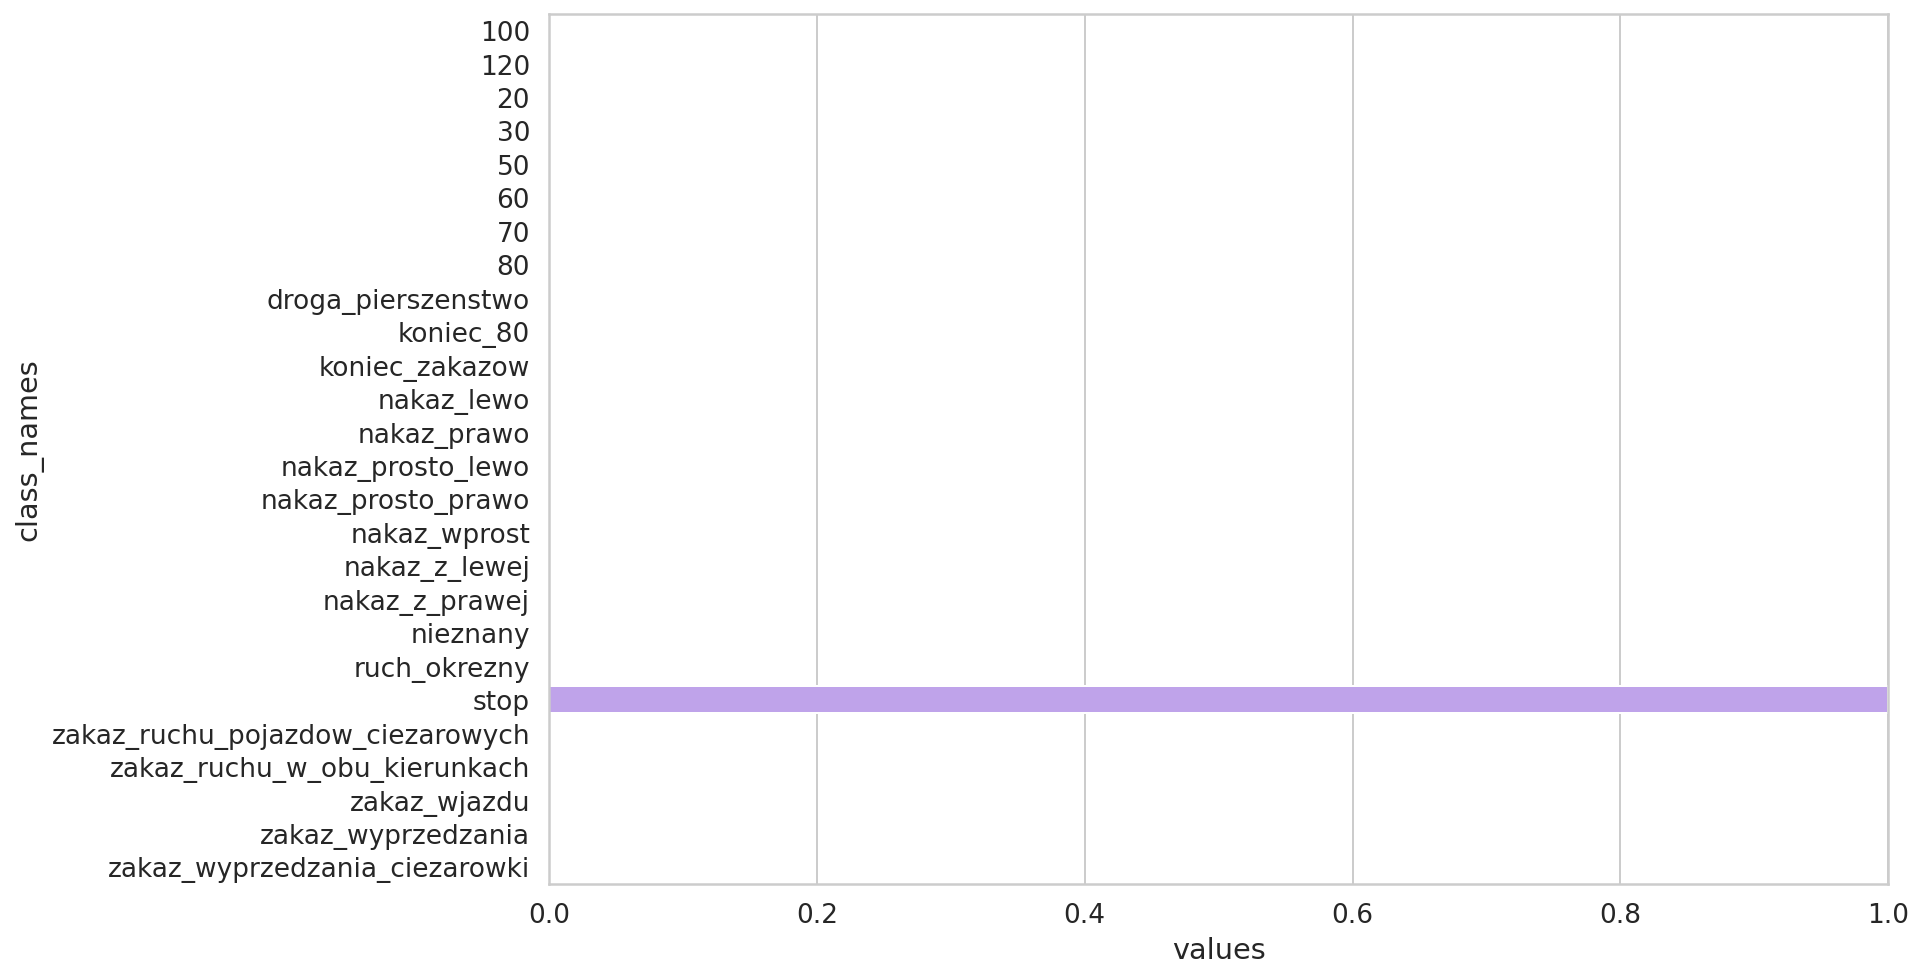

In [ ]:
pred = predict_proba(enchanced_model, 'stop3.jfif')
show_prediction_confidence(pred, class_names)

In [ ]:
pred = predict_proba(enchanced_model, 'zakaz_wjazdu.jfif')
show_prediction_confidence(pred, class_names)

In [ ]:
y_pred, y_test = get_predictions(enchanced_model, data_loaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

# WYkresy uczenia


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


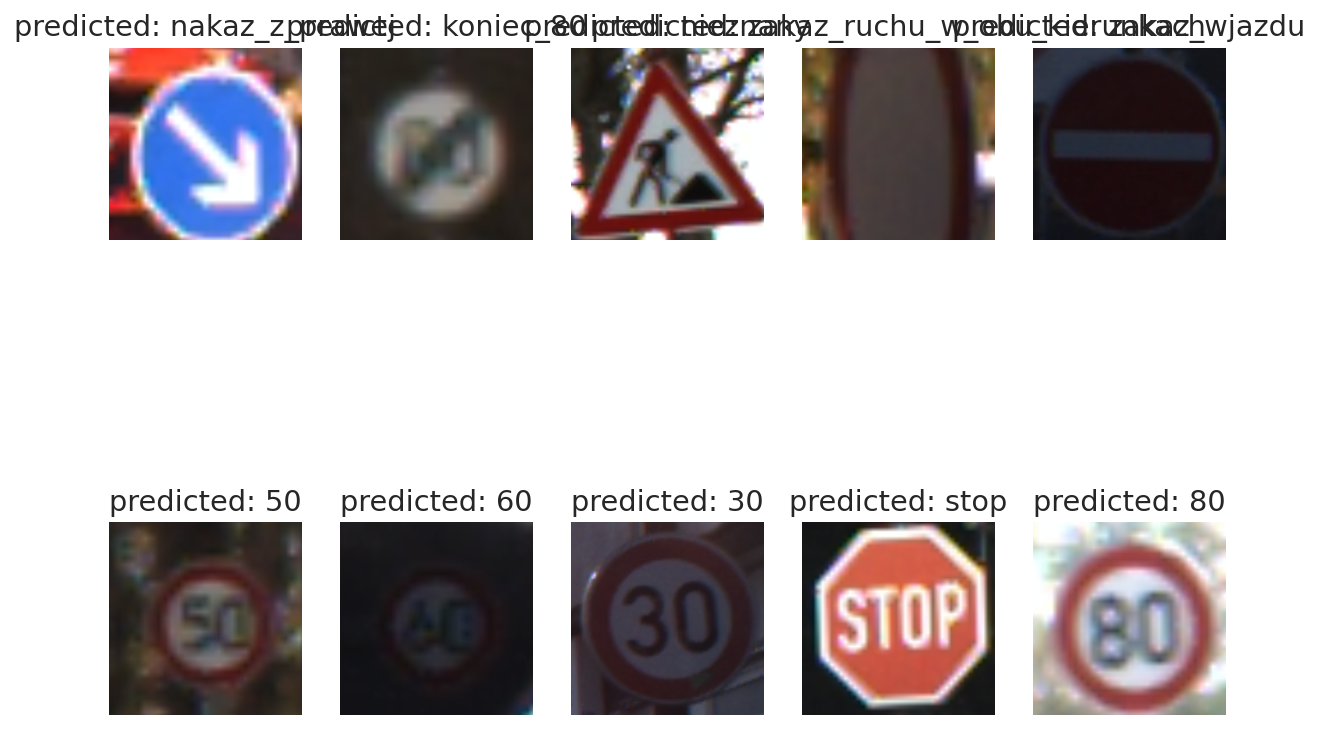

In [ ]:
show_predictions(enchanced_model, class_names, n_images=10)

In [ ]:
y_pred, y_test = get_predictions(enchanced_model, data_loaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

                                  precision    recall  f1-score   support

                             100       1.00      1.00      1.00       144
                             120       1.00      1.00      1.00       141
                              20       1.00      1.00      1.00        21
                              30       1.00      1.00      1.00       222
                              50       0.99      1.00      0.99       225
                              60       0.99      1.00      1.00       141
                              70       1.00      1.00      1.00       198
                              80       1.00      1.00      1.00       186
              droga_pierszenstwo       1.00      1.00      1.00       210
                       koniec_80       1.00      1.00      1.00        42
                  koniec_zakazow       1.00      1.00      1.00        24
                      nakaz_lewo       1.00      1.00      1.00        42
                     nakaz_prawo     

In [ ]:
from matplotlib import rcParams
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  
  # plt.figure(figsize=(40, 20))
  # hmap.figure(figsize=(11,8))
  rcParams['figure.figsize'] = 40.7, 15.27
  plt.ylabel('Prawdziwy znak')
  plt.xlabel('Wyznaczony znak');

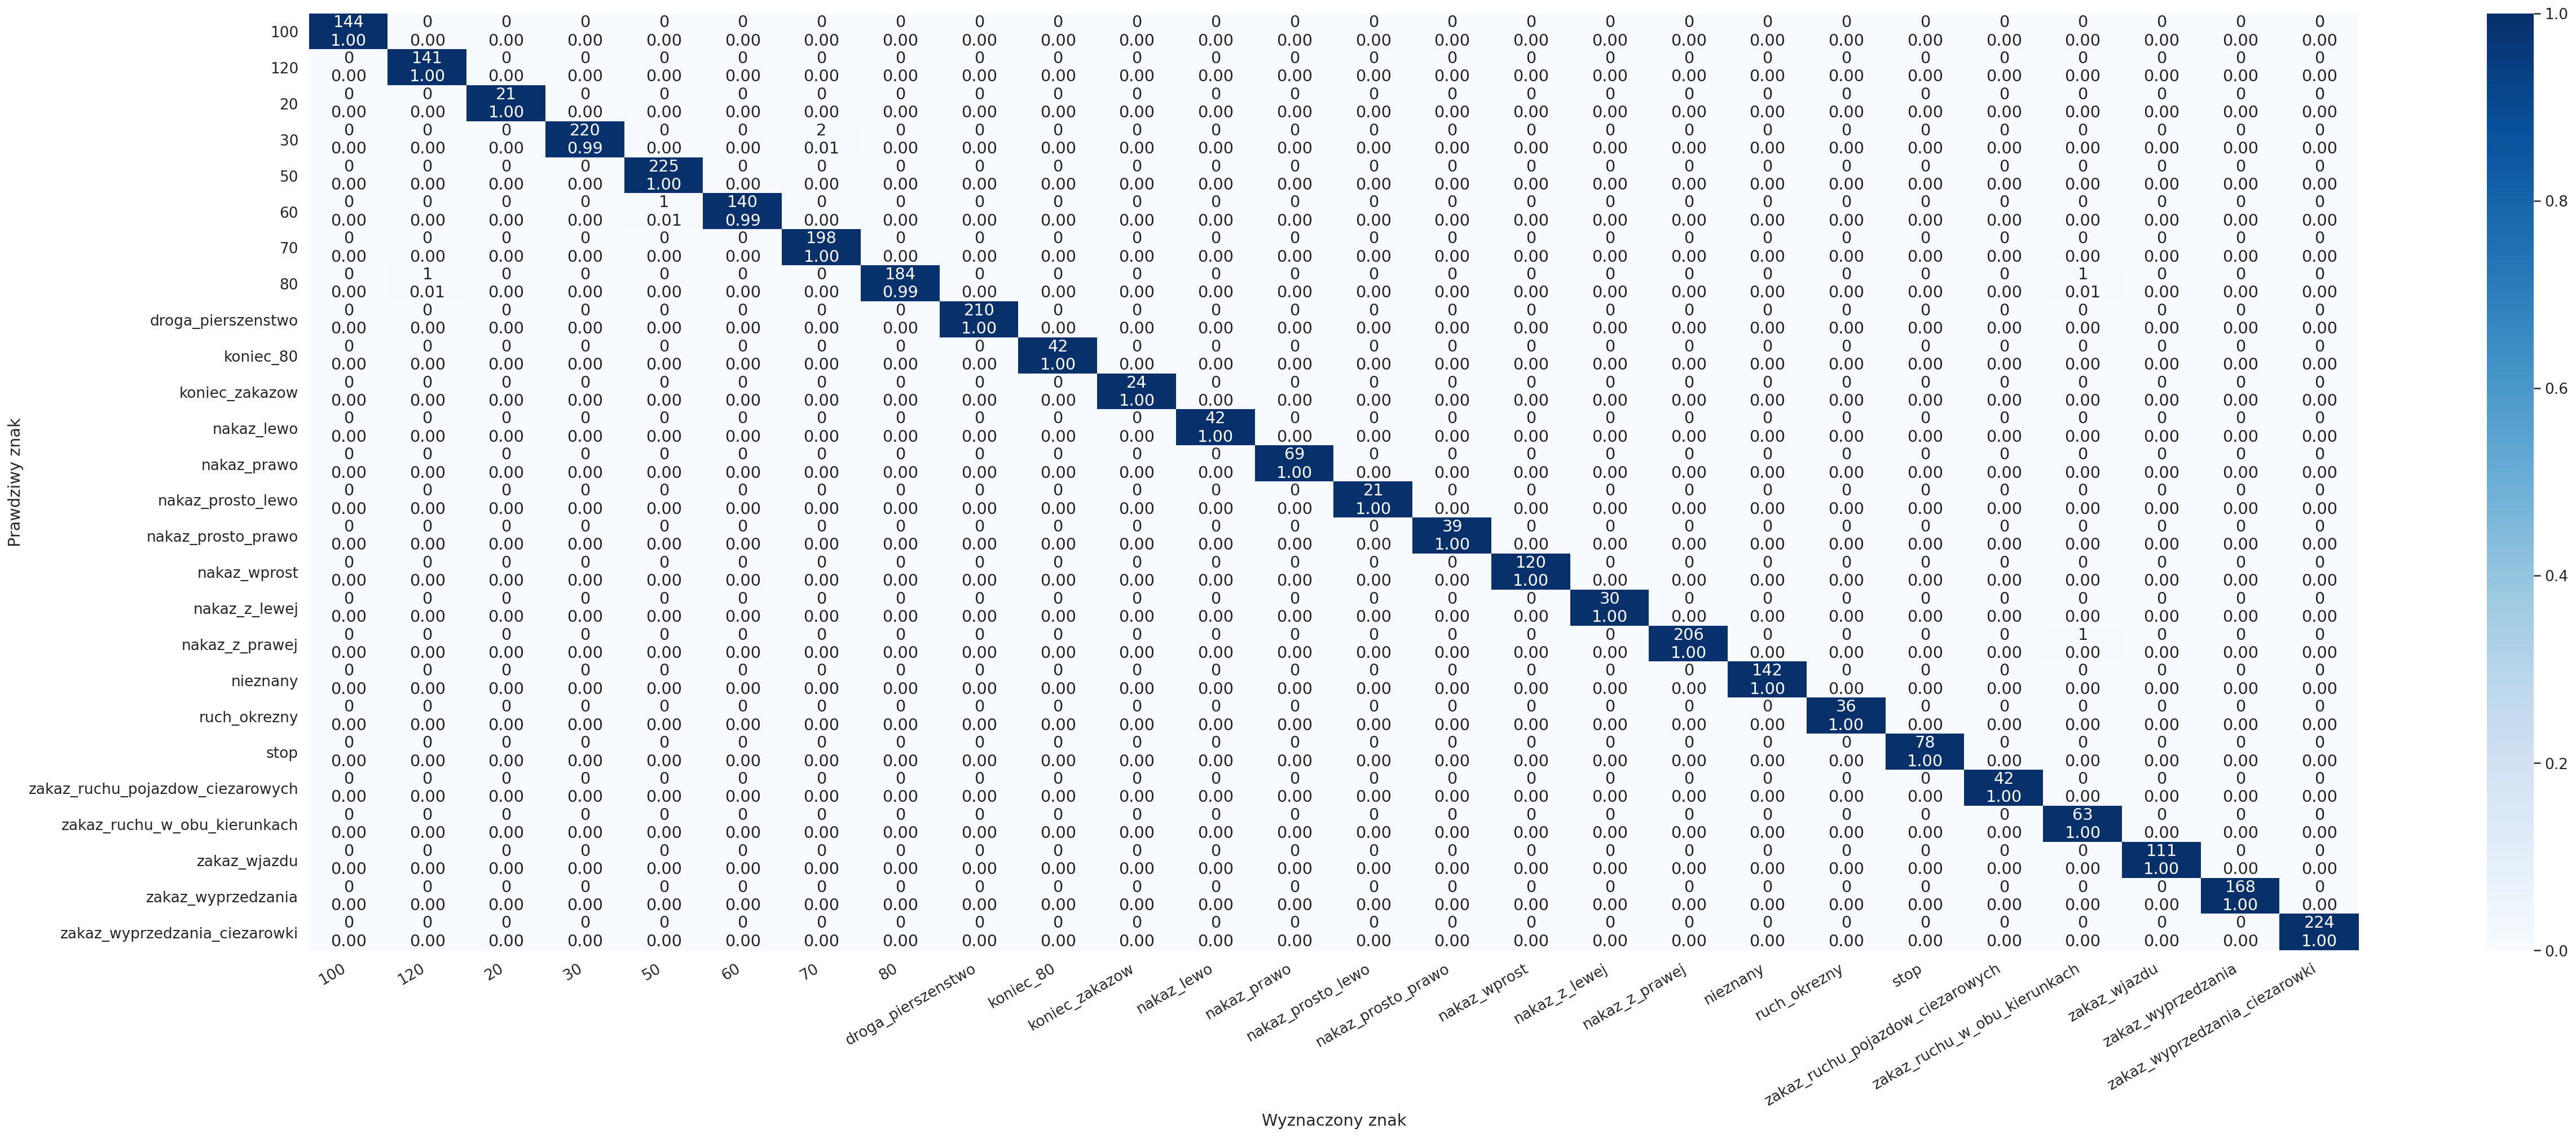

In [ ]:

cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

In [ ]:
y_test


tensor([ 1, 25,  3,  ..., 10,  1,  3])

In [ ]:
y_pred

tensor([ 1, 25,  3,  ..., 10,  1,  3])

In [ ]:
list(y_test.unique())

[tensor(0),
 tensor(1),
 tensor(2),
 tensor(3),
 tensor(4),
 tensor(5),
 tensor(6),
 tensor(7),
 tensor(8),
 tensor(9),
 tensor(10),
 tensor(11),
 tensor(12),
 tensor(13),
 tensor(14),
 tensor(15),
 tensor(16),
 tensor(17),
 tensor(18),
 tensor(19),
 tensor(20),
 tensor(21),
 tensor(22),
 tensor(23),
 tensor(24),
 tensor(25)]

In [ ]:
class_names = ['30', '40', '50', '60', '70', '100', '120', 'zakaz_wyprzedzania_ciezarowych', 
              'zakaz_ruchu_pojazdow_ciezarowych', 'nakaz_lewo', 'nakaz_prosto_lewo']

In [ ]:
class_indices = [1,2,3,4,6,7,9,12,16,34,37]

In [ ]:
len(class_indices)

Przyjmuję założenie że do analiz używam tylko i wyłącznie danych powyżej liczebności 1000 wystapien w datasecie tj.


In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')